# 'Data_processing.ipynb' is created by Yue on Apr 26, 2023 for data preprocessing.

Workflow:
1. Load original instant data of ux,uy,uz.
2. Filter by missing counts. Add flag when the number of nan exceeds 10%.
4. Despike. Add flags when the number of spikes exceeds 1%.
5. Calculate wind angle. Add flags when the wind angle is within (120,240) degrees.
6. Tilt rotation (Double rotation or planar fit).
7. Detrend (linear detrending and high-pass filtering).
8. Density correction. (neglect)
9. Spectral correction. (neglect)

Notes:
1. input directory:/save_preprocessed_data.
0. output directory: /save_processed_data.
0. q,P measurements are very weird so I didn't perform de-spiking on them.
0. qc=0: data is good; =1: data is bad.
0. webb_corr=1: correct q,T,C; =2: correct q,C; =0: no correction.
0. Do high-pass filtering on u,v,w,T with the same cutoff wavelength.
0. All the instantaneous variables will be saved in separate files by hours.
0. The hourly variables below will be saved in by days in: /save_processed_data.\
    \['ts_dspk_wind_ang', 'u_filt_size'],
    ['u_nspikes', 'v_nspikes', 'w_nspikes', 'T_nspikes'],
    ['qc_ux_nan', 'qc_uy_nan', 'qc_uz_nan', 'qc_T_nan', 'qc_q_nan', 'qc_P_nan']

=========== Disable de-spike on Sep 14, 2024 and save data to /save_processed_data_091424 =====

=========== Disable de-spike and do planar fit (by wind direction) on Oct 1, 2024 and save data to /save_processed_data_planarfit =====

=========== Disable de-spike and do planar fit (by month) on Sep 19, 2024 and save data to /save_processed_data_092024 =====

# Set up environment

In [1]:
# This jupyter notebook command inserts matplotlib graphics in to the workbook
%matplotlib inline

# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import pickle
import time
from matplotlib.pyplot import figure
import scipy.io as sio
from datetime import date, timedelta
from math import *
from scipy.stats import gmean
from scipy import ndimage
from scipy import stats
from scipy import signal
import seaborn as sns
from scipy.signal import butter,sosfiltfilt,filtfilt
from scipy import fftpack
import time
from numpy.linalg import lstsq
from collections import defaultdict

# Define parameters

In [2]:
# directories
IN_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_preprocessed_data/"
# OUT_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data/"
OUT_DIR_2rot = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/"
OUT_DIR_planarfit = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_planarfit/"
OUT_DIR_qc = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_qc/"

# List of directories to check
directories = [IN_DIR, OUT_DIR_2rot, OUT_DIR_planarfit, OUT_DIR_qc]

# Check if directories exist, create them if they don't
for dir_path in directories:
    if not os.path.exists(dir_path):
        try:
            os.makedirs(dir_path)
            print(f"Created directory: {dir_path}")
        except Exception as e:
            print(f"An error occurred while creating directory {dir_path}: {e}")
    else:
        print(f"Directory exists: {dir_path}")

# physical constants (or values that are assumed constant)
Rw  = 461.5     # ideal gas constant for water vapor, J/kg*K
Rd  = 287.05    # ideal gas constant for dry air, J/kg*K
Lv  = 1000*2257 # latent heat of vaporization (water), J/kg
Cp  = 1005      # approximate constant pressure specific heat of air, J/kg*K
k   = 0.4      # Von Karman constant
g   = 9.81      # acceleration of gravity, m/s^2

# global constants
sonum    =12                       # number of sonic
z  = np.array([1.2,2,3.5,6,9,12.5,16.5,23,30,40,50,60])  # height of sonic above ground, 
frequency=10                   # sampling rate, Hz
time_avg =3600                  # average time, s
rpat = time_avg*frequency           # number of lines for a loop

# set the range of wind angle accepted
min_wnd  = 120
max_wnd  = 240
# Define azimuth angles for the sensors
azimuth_angles = [291.9, 298.2, 299.1, 300.8, 336.6, 337.9, 339.6, 339.6, 338.8, 337.2, 337.5, 340.3]

# Filter requirements.
T = time_avg         # Sample Period
l_cutoff = 2000      # cutoff wavelength, m
order = 10       # filter order
nyq = 0.5 * frequency  # Nyquist Frequency
n = int(T * frequency) # total number of samples

# input variables
ins_var=['u_ins','v_ins','w_ins','Tsonic_ins','diag_csat_ins','q_ins','P_ins']

# output variables
out_tur = ['ux_dspk', 'uy_dspk', 'uz_dspk', 'T_dspk', 'q_ins_rnan', 'P_ins_rnan',
           'u_dspk_2rot_ldtr', 'v_dspk_2rot_ldtr', 'w_dspk_2rot_ldtr', 'T_dspk_ldtr', 
           'u_dspk_2rot_trend', 'v_dspk_2rot_trend', 'w_dspk_2rot_trend', 'T_dspk_trend',
           'u_dspk_2rot_filt', 'v_dspk_2rot_filt', 'w_dspk_2rot_filt', 'T_dspk_filt']
out_other = ['ts_dspk_wind_ang', 'u_filt_size']
out_qf = ['qc_ux_nan', 'qc_uy_nan', 'qc_uz_nan', 'qc_T_nan','qc_q_nan', 'qc_P_nan',
          'qc_ux_dspk', 'qc_uy_dspk', 'qc_uz_dspk', 'qc_T_dspk','qc_wdir_dspk']
out_nspikes = ['u_nspikes', 'v_nspikes', 'w_nspikes', 'T_nspikes']

# controls
# webb_corr = 2 # do webb-corr on q and C only

Directory exists: /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_preprocessed_data/
Directory exists: /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/
Directory exists: /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_planarfit/
Directory exists: /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_qc/


# Define functions

In [3]:
def date_list(sdate,edate):
    """method used for creating date list"""
    delta = edate - sdate       # as timedelta
    day = [sdate+timedelta(days=x) for x in range(delta.days+1)]
    return day

def rmnan(data,flag):  
    """ method used for checking & rm nan"""  
    data[flag >= 65] = np.nan ## ！！！！！ get rid of bad data (thershold is 65)! ! ! ! !
    nansum = np.sum(np.isnan(data))
    qc = 0
    if nansum >= time_avg*frequency/10:
        data[:] = np.nan
        qc = 1
    return data,qc
    # for icol in range(sonum):
    #     nansum = np.sum(np.isnan(data[:,icol]),0)
    #     # if there are more than 10% nan in an hour, discard all data at that level
    #     if nansum >= time_avg*frequency/10:
    #         data[:,icol] = np.nan
    # return data
def get_wind_ang(ux,uy,nl):
    """
    !!!arctan return values in radians!!!
    for 1 level only
    calculate mean wind angle on the xy-plane (!! must do before double rotation)
    Assume: The CSAT3 (the anemometer arms, tripods) is aligned northward and if u is positive, the wind is northerly. 
    If v is positive, the wind is westerly.
    u:north(+)->south(-), v:west(+)->east(-)
    """
    u_avg = np.nanmean(ux,axis=0) # size = 1
    v_avg = np.nanmean(uy,axis=0)
    rot_ang_v = degrees(np.arctan(v_avg/u_avg))
    # print('nl='+str(nl))
    # if nl==2:
    #     wind_ang = rot_ang_v*np.nan
    #     mask1 = np.logical_and(u_avg>=0, v_avg<=0)
    #     wind_ang[mask1] = -rot_ang_v[mask1] # northeast
    #     mask2 = np.logical_and(u_avg<=0, v_avg<=0)
    #     wind_ang[mask2] = 180-rot_ang_v[mask2] # southest
    #     mask3 = np.logical_and(u_avg<=0, v_avg>=0)
    #     wind_ang[mask3] = 180-rot_ang_v[mask3] # southwest
    #     mask4 = np.logical_and(u_avg>=0, v_avg>=0)
    #     wind_ang[mask4] = 360-rot_ang_v[mask4] # northwest         
    if nl==1:
        wind_ang = rot_ang_v
        if np.logical_and(u_avg>=0, v_avg<=0):
            wind_ang = -rot_ang_v # northeast
        if np.logical_and(u_avg<=0, v_avg<=0):
            wind_ang = 180-rot_ang_v # southest
        if np.logical_and(u_avg<=0, v_avg>=0):
            wind_ang = 180-rot_ang_v # southwest
        if np.logical_and(u_avg>=0, v_avg>=0):
            wind_ang = 360-rot_ang_v # northwest 
    return wind_ang

def wind_ang(ux,uy):
    """
    calculate mean wind angle on the xy-plane (!! must do before double rotation)
    The CSAT3 (the anemometer arms, tripods) is aligned northward and if u is positive, the wind is northerly. 
    If v is positive, the wind is westerly.
    u:north(+)->south(-), v:west(+)->east(-)
    """
    u_avg = np.nanmean(ux,axis=0) # size = 12
    v_avg = np.nanmean(uy,axis=0)
    rot_ang_v = np.arctan(v_avg/u_avg)
    rot_ang_v = rot_ang_v*360/2/math.pi
    mask1 = np.logical_and(u_avg>=0, v_avg<=0)
    rot_ang_v[mask1] = -rot_ang_v[mask1] # northeast
    mask2 = np.logical_and(u_avg<=0, v_avg<=0)
    rot_ang_v[mask2] = 180-rot_ang_v[mask2] # southest
    mask3 = np.logical_and(u_avg<=0, v_avg>=0)
    rot_ang_v[mask3] = 180-rot_ang_v[mask3] # southwest
    mask4 = np.logical_and(u_avg>=0, v_avg>=0)
    rot_ang_v[mask4] = 360-rot_ang_v[mask4] # northwest
    
    # quality control: wind angle>120 and < 240
    qc = np.zeros(12)
    msk = np.logical_and(rot_ang_v> min_wnd,rot_ang_v<max_wnd)
    qc[msk] = 1
    return rot_ang_v,qc

def double_rot(ux,uy,uz):
    """
    Double rotation method (Note yaw correction must perform before pitch correction)
    https://www.licor.com/env/support/EddyPro/topics/anemometer-tilt-correction.html#:~:
    text=Double%20rotation%20method,by%20the%20flux%20averaging%20length.
    # such that the hourly avg of v and w will be zero
    # only u,v,w will be rotated, other variables remain the same
    """
    u_avg = np.nanmean(ux,axis=0) # size = 12
    v_avg = np.nanmean(uy,axis=0)
    w_avg = np.nanmean(uz,axis=0)
    # 1) yaw rotation (to remove v component)
    C1 = (u_avg**2 + v_avg**2) ** 0.5 # Magnitude of horizontal wind vector
    rot_mat_1 = u_avg/C1 # cos(theta)
    rot_mat_2 = v_avg/C1 # sin(theta)
    rot_mat_3 = -v_avg/C1
    rot_mat_4 = u_avg/C1
    u_rot = ux * rot_mat_1 + uy*rot_mat_2
    v_rot = ux * rot_mat_3 + uy*rot_mat_4
    u_ins_yawrot = u_rot # Intermediate rotated u after yaw correction
    v_ins_2rot = v_rot
    u_avg_yawrot = np.nanmean(u_ins_yawrot,axis=0) # Recompute u mean after yaw rotation
    # v_avg_2rot = np.nanmean(v_ins_2rot,axis=0)

    # 2) pitch rotation (to remove w component)
    C2 = (u_avg_yawrot**2 + w_avg**2) ** 0.5 # Magnitude of u-w plane vector
    rot_mat_1 = u_avg_yawrot/C2
    rot_mat_2 = w_avg/C2  # cos(phi)
    rot_mat_3 =-w_avg/C2  # sin(phi)
    rot_mat_4 = u_avg_yawrot/C2
    u_rot = u_ins_yawrot * rot_mat_1 + uz*rot_mat_2
    w_rot = u_ins_yawrot * rot_mat_3 + uz*rot_mat_4
    u_ins_2rot = u_rot
    w_ins_2rot = w_rot
    # u_avg_2rot = np.nanmean(u_ins_2rot,axis=0)
    # w_avg_2rot = np.nanmean(w_ins_2rot,axis=0)
    
    return u_ins_2rot,v_ins_2rot,w_ins_2rot


def planar_fit_with_monthly_rotation_matrix(ux, uy, uz, rotation_matrices):
    """
    Apply the traditional planar fit method using precomputed rotation matrices for each level.

    Parameters:
    - ux: (36000, 12) array-like, instantaneous velocity in x direction (streamwise wind component)
    - uy: (36000, 12) array-like, instantaneous velocity in y direction (crosswise wind component)
    - uz: (36000, 12) array-like, instantaneous velocity in z direction (vertical wind component)
    - rotation_matrices: (12, 3, 3) array-like, precomputed rotation matrices for each level
    
    Returns:
    - u_corrected: corrected velocity in x direction (36000, 12)
    - v_corrected: corrected velocity in y direction (36000, 12)
    - w_corrected: corrected velocity in z direction (36000, 12) (should have a zero long-term mean)
    """
    
    n_timestamps, n_levels = ux.shape
    
    # Initialize arrays for the corrected wind components
    u_corrected = np.zeros((n_timestamps, n_levels))
    v_corrected = np.zeros((n_timestamps, n_levels))
    w_corrected = np.zeros((n_timestamps, n_levels))
    
    # Apply planar fit using stored rotation matrices for each level
    for level in range(n_levels):
        # Step 1: Mask out NaN values for the current level
        valid_mask = ~np.isnan(ux[:, level]) & ~np.isnan(uy[:, level]) & ~np.isnan(uz[:, level])
        ux_valid = ux[valid_mask, level]
        uy_valid = uy[valid_mask, level]
        uz_valid = uz[valid_mask, level]

        if len(ux_valid) == 0:
            continue  # Skip to next level if no valid data
        
        # Step 2: Retrieve the precomputed rotation matrix for this level
        M_pf = rotation_matrices[level]
        
        # Step 3: Create wind matrix from the valid wind components
        wind_matrix = np.vstack([ux[:, level], uy[:, level], uz[:, level]]).T  # (36000, 3)
        
        # Apply the rotation matrix to valid rows
        rotated_wind = wind_matrix[valid_mask] @ M_pf  # Rotate wind components (N_valid, 3)

        # Step 4: Apply a third rotation to align the wind components
        # This could be a yaw rotation (rotation about the z-axis)
        gamma = np.arctan2(np.mean(rotated_wind[:, 1]), np.mean(rotated_wind[:, 0]))  # Yaw angle based on mean u and v
        
        M_yaw = np.array([
            [np.cos(gamma), -np.sin(gamma), 0],
            [np.sin(gamma), np.cos(gamma), 0],
            [0, 0, 1]
        ])
        
        # Apply the yaw rotation to the already rotated wind components
        final_rotated_wind = rotated_wind @ M_yaw
        
        # Store the corrected wind components for valid indices
        u_corrected[valid_mask, level] = final_rotated_wind[:, 0]
        v_corrected[valid_mask, level] = final_rotated_wind[:, 1]
        w_corrected[valid_mask, level] = final_rotated_wind[:, 2]
    
    return u_corrected, v_corrected, w_corrected

# def butter_lowpass_filter(filt_type, data, cutoff, fs, order):
#     """
#     The frequency response of the Butterworth filter is maximally flat 
#     (i.e. has no ripples) in the passband and rolls off towards zero in the stopband, 
#     hence its one of the most popular low pass filter.
    
#     data shoule be turbulent component!
#     """
#     # replace nan by mean value
#     data[np.argwhere(np.isnan(data))] = np.nanmean(data)
#     normal_cutoff = cutoff / nyq
#     # Get the filter coefficients 
#     sos = butter(order, normal_cutoff, btype=filt_type, analog=False, output='sos',fs=fs)
#     # Return the filtered output with the same shape as data
#     # The function sosfiltfilt should be preferred over filtfilt 
#     # for most filtering tasks, as second-order sections have fewer numerical problems.
#     y = sosfiltfilt(sos, data) 
#     return y


def butter_lowpass_filter(filt_type, data, cutoff, fs, order):
    """
    The frequency response of the Butterworth filter is maximally flat 
    (i.e. has no ripples) in the passband and rolls off towards zero in the stopband, 
    hence its one of the most popular low pass filter.
    """
    # Compute the normal cutoff frequency
    normal_cutoff = cutoff / nyq
    
    # Check that normal_cutoff is within (0, 1)
    if not 0 < normal_cutoff < 1:
        raise ValueError(f"Invalid cutoff frequency: {cutoff}. It must be between 0 and {nyquist} Hz.")
    
    # Count NaNs in the data and print the count
    nan_count = np.isnan(data).sum()
    if nan_count > 0:
        # print(f"NaN count before interpolation: {nan_count}")
        # Interpolate NaN values in the data
        data = np.interp(np.arange(len(data)), np.arange(len(data))[~np.isnan(data)], data[~np.isnan(data)])
        # data[np.argwhere(np.isnan(data))] = np.nanmean(data)
    # Design the Butterworth filter
    sos = butter(order, normal_cutoff, btype=filt_type, analog=False, output='sos',fs=fs)
    
    # Debug: Print the filter coefficients
    # print("Second-order sections (sos):\n", sos)
    
    # Apply the filter
    # Return the filtered output with the same shape as data
    # The function sosfiltfilt should be preferred over filtfilt 
    # for most filtering tasks, as second-order sections have fewer numerical problems.
    try:
        y = sosfiltfilt(sos, data)
    except np.linalg.LinAlgError as e:
        print("Error during filtering:", e)
        print("Attempting to use sosfilt instead of sosfiltfilt.")
        y = sosfilt(sos, data)
    
    return y

def get_u_star(u_tur_in,v_tur_in,w_tur_in):
    uw = np.nanmean(u_tur_in*w_tur_in,axis=0)
    vw = np.nanmean(v_tur_in*w_tur_in,axis=0)
    u_star = (np.maximum(0,(uw**2+vw**2)**0.5))**0.5
    return u_star
  

def dtrd(data):
    # Only return the turbulent component  
    # The result is equal to signal.detrend(data)+np.mean(data)
    ct = np.arange(len(data))
    a = -(len(data)*np.nansum(ct*data, axis=0) - np.nansum(ct, axis=0) * 
          np.nansum(data, axis=0)) / (np.nansum(ct**2, axis=0)-(np.nansum(ct, axis=0))**2)
    b = (np.nansum(data, axis=0) - a * np.nansum(ct, axis=0))/len(data)
    data_dtr = data + (a*ct+b) - np.nanmean(data)
    return data_dtr

def get_ist(data):
    """
    Return the non-stationarity index for every hourly time series 
    """
    data_5min = data.reshape([12,-1]) # split each hour into 12 chunks/every 5 min
    cvm = np.nanmean(np.nanvar(data_5min,axis=1)) # avg of the variance of each chunck
    ist_5min = abs(cvm-np.nanvar(data))/np.nanvar(data)
    return ist_5min

def z_score(intensity):
    """
    Z-score based approach for spike detection
    """
    mean_int = np.nanmean(intensity)
    std_int = np.nanstd(intensity)
    z_scores = (intensity-mean_int) / std_int
    return z_scores

def fixer_backup(y,thres):
    """
    remove spikes and fix them with the mean of its immediate neighbors.
    Following Vickers and Mahrt (1997), 
    https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html
    """
    qc = 0
    it = 0
    y_original = y.copy()
    while it < 20: # iterate 20 times
        # print(f"the {it} iterations:")
        # print(f"the 0 windows")
        y_sub = y[0:12000] # moving window is 20 min
        y_fix = y_sub.copy()
        spikes = abs(np.array(z_score(y_sub))) > thres
        n_con_spk = 0 # counts of more than 4 consecutive spikes
        for i in np.where(spikes != 0)[0]:  # If we have an spike in position i
            if i == 12000 - 1:
                w2 = np.arange(i-3,i+1)
                w1 = w2
            elif i == 12000 - 2:
                w2 = np.arange(i-4,i)
                w1 = np.arange(i-3,i+1)
            elif i == 12000 - 3:
                w2 = np.arange(i-5,i-1)
                w1 = np.arange(i-3,i+1)
            else:
                w1 = np.arange(i-3,i+1)
                w2 = np.arange(i,i+4)
            # 4 consecutive outliers
            # are considered as a local trend and not counted as a spike. 
            if np.sum(spikes[w1])==4 or np.sum(spikes[w2])==4:
                # print(f"4 consecutive spikes.")
                n_con_spk += 1
            else:
                if i == 12000 - 1:
                    w = np.arange(12000-3,12000)
                else:
                    w = np.arange(i-1,i+2) # we select 3 points around our spike
                ww = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                y_fix[i] = np.mean(y_sub[ww]) # and we average their values
        # nspikes = np.nansum(spikes) - n_con_spk
        y_new = y_fix
        # 2nd to 6th moving window
        for iw in np.arange(1,5):
            n_con_spk = 0
            # print(f"the {iw} windows")
            y_sub = y[iw*6000:iw*6000+12000]
            y_fix = y_sub.copy()
            spikes = abs(np.array(z_score(y_sub))) > thres
            for i in np.where(spikes != 0)[0]:  # If we have an spike in position i
                if i >= 6000:
                    if i == 12000 - 1:
                        w2 = np.arange(i-3,i+1)
                        w1 = w2
                    elif i == 12000 - 2:
                        w2 = np.arange(i-4,i)
                        w1 = np.arange(i-3,i+1)
                    elif i == 12000 - 3:
                        w2 = np.arange(i-5,i-1)
                        w1 = np.arange(i-3,i+1)
                    else:
                        w1 = np.arange(i-3,i+1)
                        w2 = np.arange(i,i+4)
                    # 4 consecutive outliers
                    # are considered as a local trend and not counted as a spike. 
                    if np.sum(spikes[w1])==4 or np.sum(spikes[w2])==4:         
                        # print(f"4 consecutive spikes.")
                        n_con_spk += 1
                    else:
                        if i == 12000 - 1:
                            w = np.arange(12000-3,12000)
                        else:
                            w = np.arange(i-1,i+2) # we select 3 points around our spike
                        ww = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                        y_fix[i] = np.mean(y_sub[ww]) # and we average their values
            nspk = np.nansum(spikes[6000:12000]) - n_con_spk
            y_new = np.append(y_new,y_fix[6000:12000])
            # nspikes += nspk
        # print(f"{nspikes} spikes")
        # print("-----------")        
        # if it == 0:
        #     n_spikes = nspikes
        # else:
        n_spikes = np.sum((y_new-y_original)!=0)
        if n_spikes > 0.01*rpat: # accepted spikes is 1%
            qc = 1 # quality flag = 1, should be discarded from the results dataset.
            print("Too much number of spikes")
            break
        if n_spikes == 0:
            break
        y = y_new
        it += 1
    return y_new,qc,n_spikes

def fixer(y,thres):
    """
    remove spikes and fix them with the mean of its immediate neighbors.
    Following Vickers and Mahrt (1997), 
    https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html
    """
    qc = 0
    it = 0
    y_original = y.copy()
    while it < 20: # iterate 20 times
        # print(f"the {it} iterations:")
        # print(f"the 0 windows")
        y_sub = y[0:12000] # moving window is 20 min
        y_fix = y_sub.copy()
        spikes = abs(np.array(z_score(y_sub))) > thres
        n_con_spk = 0 # counts of more than 4 consecutive spikes
        for i in np.where(spikes)[0]:  # If we have an spike in position i
            if i == 12000 - 1:
                w2 = np.arange(i-3,i+1)
                w1 = w2
            elif i == 12000 - 2:
                w2 = np.arange(i-4,i)
                w1 = np.arange(i-3,i+1)
            elif i == 12000 - 3:
                w2 = np.arange(i-5,i-1)
                w1 = np.arange(i-3,i+1)
            else:
                w1 = np.arange(i-3,i+1)
                w2 = np.arange(i,i+4)
            # 4 consecutive outliers
            # are considered as a local trend and not counted as a spike. 
            if np.sum(spikes[w1])==4 or np.sum(spikes[w2])==4:
                # print(f"4 consecutive spikes.")
                n_con_spk += 1
            else:
                if i == 12000 - 1:
                    w = np.arange(12000-3,12000)
                else:
                    w = np.arange(i-1,i+2) # we select 3 points around our spike
                ww = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                y_fix[i] = np.mean(y_sub[ww]) # and we average their values
        # nspikes = np.nansum(spikes) - n_con_spk
        y_new = y_fix
        # 2nd to 6th moving window
        for iw in np.arange(1,5):
            n_con_spk = 0
            # print(f"the {iw} windows")
            y_sub = y[iw*6000:iw*6000+12000]
            y_fix = y_sub.copy()
            spikes = abs(np.array(z_score(y_sub))) > thres
            for i in np.where(spikes)[0]:  # If we have an spike in position i
                if i >= 6000:
                    if i == 12000 - 1:
                        w2 = np.arange(i-3,i+1)
                        w1 = w2
                    elif i == 12000 - 2:
                        w2 = np.arange(i-4,i)
                        w1 = np.arange(i-3,i+1)
                    elif i == 12000 - 3:
                        w2 = np.arange(i-5,i-1)
                        w1 = np.arange(i-3,i+1)
                    else:
                        w1 = np.arange(i-3,i+1)
                        w2 = np.arange(i,i+4)
                    # 4 consecutive outliers
                    # are considered as a local trend and not counted as a spike. 
                    if np.sum(spikes[w1])==4 or np.sum(spikes[w2])==4:         
                        # print(f"4 consecutive spikes.")
                        n_con_spk += 1
                    else:
                        if i == 12000 - 1:
                            w = np.arange(12000-3,12000)
                        else:
                            w = np.arange(i-1,i+2) # we select 3 points around our spike
                        ww = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                        y_fix[i] = np.mean(y_sub[ww]) # and we average their values
            nspk = np.nansum(spikes[6000:12000]) - n_con_spk
            y_new = np.append(y_new,y_fix[6000:12000])
            # nspikes += nspk
        # print(f"{nspikes} spikes")
        # print("-----------")        
        # if it == 0:
        #     n_spikes = nspikes
        # else:
        n_spikes = np.sum((y_new-y_original)!=0)
        if n_spikes > 0.01*rpat: # accepted spikes is 1%
            qc = 1 # quality flag = 1, should be discarded from the results dataset.
            print("Too much number of spikes")
            break
        if n_spikes == 0:
            break
        y = y_new
        it += 1
    return y_new,qc,n_spikes


def abs_lim(y,lim):
    """
    After de-spiking,
    replace a value that is outside a user-defined plausible range 
    by the mean of neiboring variables. 
    """
    out_lier = abs(y)>lim
    # print(np.sum(out_lier))
    y_lim = y.copy()
    for i in np.where(out_lier!=0)[0]:
        w = np.arange(i-2,i+3) # select 5 points around 
        w2 = w[out_lier[w] == 0] # From such interval, we choose the ones which are not outliers
        y_lim[i] = np.mean(y[w2]) # and we average their values
    return y_lim

def CheckForLess(list1, val): 
    # traverse in the list
    for x in list1: 
        # compare with all the
        # values with value
        if val <= x:
            return False
    return True

def compute_sector_data(u_valid, v_valid, w_valid):
    if len(u_valid) >= 3:
        # Prepare data for regression
        A = np.vstack([u_valid, v_valid, np.ones_like(u_valid)]).T
        b = w_valid

        # Perform least squares regression
        coeffs, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        b1, b2, b0 = coeffs

        # Calculate R²
        w_pred = A @ coeffs
        ss_res = np.sum((b - w_pred) ** 2)
        ss_tot = np.sum((b - np.mean(b)) ** 2)
        R2 = 1 - (ss_res / ss_tot)

        # Calculate tilt angles
        alpha = np.arctan(-b1)
        beta = np.arctan(b2)

        # Construct rotation matrix
        cos_beta, sin_beta = np.cos(beta), np.sin(beta)
        C_T = np.array([[1, 0, 0], [0, cos_beta, sin_beta], [0, -sin_beta, cos_beta]])

        cos_alpha, sin_alpha = np.cos(alpha), np.sin(alpha)
        D_T = np.array([[cos_alpha, 0, -sin_alpha], [0, 1, 0], [sin_alpha, 0, cos_alpha]])

        P = D_T @ C_T

        return {'alpha': alpha, 'beta': beta}, P, {'b0': b0, 'b1': b1, 'b2': b2, 'R2': R2}
    return None, None, None

def compute_sector_data_origin(u_valid, v_valid, w_valid):
    if len(u_valid) >= 3:
        # Prepare data for regression with constraint of passing through origin (b0 = 0)
        A = np.vstack([u_valid, v_valid]).T
        b = w_valid

        # Perform least squares regression without intercept (forcing origin)
        coeffs, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        b1, b2 = coeffs
        b0 = 0  # Enforce passing through the origin

        # Calculate R²
        w_pred = A @ coeffs
        ss_res = np.sum((b - w_pred) ** 2)
        ss_tot = np.sum((b - np.mean(b)) ** 2)
        R2 = 1 - (ss_res / ss_tot)

        # Calculate tilt angles
        alpha = np.arctan(-b1)
        beta = np.arctan(b2)

        # Construct rotation matrix
        cos_beta, sin_beta = np.cos(beta), np.sin(beta)
        C_T = np.array([[1, 0, 0], [0, cos_beta, sin_beta], [0, -sin_beta, cos_beta]])

        cos_alpha, sin_alpha = np.cos(alpha), np.sin(alpha)
        D_T = np.array([[cos_alpha, 0, -sin_alpha], [0, 1, 0], [sin_alpha, 0, cos_alpha]])

        P = D_T @ C_T

        return {'alpha': alpha, 'beta': beta}, P, {'b0': b0, 'b1': b1, 'b2': b2, 'R2': R2}
    
    return None, None, None


def planar_fit_with_sector_rotation_matrix(ux, uy, uz, rotation_matrices_df):
    """
    Apply the planar fit method using precomputed rotation matrices based on sector flags.

    Parameters:
    - ux: (36000, 1) array-like, instantaneous velocity in the x direction (streamwise wind component)
    - uy: (36000, 1) array-like, instantaneous velocity in the y direction (crosswise wind component)
    - uz: (36000, 1) array-like, instantaneous velocity in the z direction (vertical wind component)
    - rotation_matrices_df: DataFrame containing precomputed rotation matrices for each sector (specified) and level.
      The DataFrame has columns ['sector', 'key', 'r11', 'r12', 'r13', 'r21', 'r22', 'r23', 'r31', 'r32', 'r33'].

    Returns:
    - u_corrected: corrected velocity in the x direction (36000, 1)
    - v_corrected: corrected velocity in the y direction (36000, 1)
    - w_corrected: corrected velocity in the z direction (36000, 1) (should have a zero long-term mean)
    """
    
    # n_timestamps, n_levels = ux.shape
    
    # Initialize arrays for the corrected wind components
    u_corrected = ux.copy()
    v_corrected = uy.copy()
    w_corrected = uz.copy()
    
    # Apply planar fit using stored rotation matrices based on sectors and levels
    # for level in range(n_levels):
    # Step 1: Mask out NaN values for the current level
    valid_mask = ~np.isnan(ux) & ~np.isnan(uy) & ~np.isnan(uz)
    ux_valid = ux[valid_mask]
    uy_valid = uy[valid_mask]
    uz_valid = uz[valid_mask]

    if len(ux_valid) == 0:
        print("no valid data")
        return u_corrected, v_corrected, w_corrected  # Return if no valid data
    
    if rotation_matrices_df.empty:
        print("Empty rotation matrix row")
        return u_corrected, v_corrected, w_corrected  # Return if no rotation matrix for this sector
    
    # Convert the matrix elements into a 3x3 rotation matrix
    M_pf = rotation_matrices_df[['r11', 'r12', 'r13', 'r21', 'r22', 'r23', 'r31', 'r32', 'r33']].values.reshape(3, 3)
    
    # Step 3: Create wind matrix from the valid wind components
    wind_matrix = np.vstack([ux[valid_mask], uy[valid_mask], uz[valid_mask]]).T  # (N_valid, 3)
    
    # Apply the rotation matrix to the wind components
    rotated_wind = wind_matrix @ M_pf  # Rotate wind components (N_valid, 3)

    # Apply a third rotation to align the wind components (yaw rotation)
    gamma = np.arctan2(np.mean(rotated_wind[:, 1]), np.mean(rotated_wind[:, 0]))  # Yaw angle based on mean u and v
    
    M_yaw = np.array([
        [np.cos(gamma), -np.sin(gamma), 0],
        [np.sin(gamma), np.cos(gamma), 0],
        [0, 0, 1]
    ])
    
    # Apply the yaw rotation to the already rotated wind components
    final_rotated_wind = rotated_wind @ M_yaw
    
    # Store the corrected wind components for valid indices
    u_corrected[valid_mask] = final_rotated_wind[:, 0]
    v_corrected[valid_mask] = final_rotated_wind[:, 1]
    w_corrected[valid_mask] = final_rotated_wind[:, 2]
    
    return u_corrected, v_corrected, w_corrected

# Set up processing

In [4]:
# set up time period and initialize variables
Sdate = date(2020,9,25)
# Sdate = date(2020,12,1)
Edate = date(2021,4,23)
# Edate = date(2020,9,26)
ds = date_list(Sdate,Edate)

# Optional: Calculate b1 and b2 for planar fit by monthly separated data

In [7]:
# Assuming 'ds' is a list of datetime objects representing each day
# Ensure 'ds' is sorted
ds = sorted(ds)
# Initialize a dictionary to store monthly data
monthly_data = defaultdict(lambda: {'u_hourly_means': [], 'v_hourly_means': [], 'w_hourly_means': []})

# Step 1
# Loop through each day
for day in ds:
    strday = day.strftime("%Y%m%d")
    month_str = day.strftime("%Y-%m")  # Format: 'YYYY-MM' for grouping by month
    fp_stats = IN_DIR + 'u_ins_' + strday + '.pkl'
    if not os.path.isfile(fp_stats):
        print(f"{strday} does not exist")
        continue
    print(f"Start processing: {strday}")
    for var in ['u_ins','v_ins','w_ins']:
        a_file = open(IN_DIR + var + '_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)
        a_file.close()
     # Reshape data
    u_ins3d = u_ins.reshape(-1, rpat, sonum)  # Shape: (24, 36000, 12)
    v_ins3d = v_ins.reshape(-1, rpat, sonum)
    w_ins3d = w_ins.reshape(-1, rpat, sonum)

    # Compute hourly averages
    u_hourly_means_day = np.nanmean(u_ins3d, axis=1)  # Shape: (24, 12)
    v_hourly_means_day = np.nanmean(v_ins3d, axis=1)
    w_hourly_means_day = np.nanmean(w_ins3d, axis=1)

    # Append hourly means to the monthly data
    monthly_data[month_str]['u_hourly_means'].append(u_hourly_means_day)
    monthly_data[month_str]['v_hourly_means'].append(v_hourly_means_day)
    monthly_data[month_str]['w_hourly_means'].append(w_hourly_means_day)

Start processing: 20200925
Start processing: 20200926
Start processing: 20200927
Start processing: 20200928
Start processing: 20200929
Start processing: 20200930
Start processing: 20201001
Start processing: 20201002
Start processing: 20201003
Start processing: 20201004
Start processing: 20201005
Start processing: 20201006
Start processing: 20201007
Start processing: 20201008
Start processing: 20201009
Start processing: 20201010
Start processing: 20201011
Start processing: 20201012
Start processing: 20201013
Start processing: 20201014
Start processing: 20201015
Start processing: 20201016
Start processing: 20201017
Start processing: 20201018
Start processing: 20201019
Start processing: 20201020
Start processing: 20201021
Start processing: 20201022
Start processing: 20201023
Start processing: 20201024
Start processing: 20201025
Start processing: 20201026
Start processing: 20201027
Start processing: 20201028
Start processing: 20201029
Start processing: 20201030
Start processing: 20201031
S

In [8]:
# Step 2
# Compute tilt angles and rotation matrices for each month and level
monthly_tilt_angles = {}
monthly_rotation_matrices = {}
monthly_regression_coeffs = {}  # New dictionary to store b0, b1, b2

for month_str, data_dict in monthly_data.items():
    print(f"Processing month: {month_str}")

    # Concatenate the hourly means
    u_hourly_means = np.concatenate(data_dict['u_hourly_means'], axis=0)  # Shape: (n_hours_in_month, 12)
    v_hourly_means = np.concatenate(data_dict['v_hourly_means'], axis=0)
    w_hourly_means = np.concatenate(data_dict['w_hourly_means'], axis=0)

    n_hours_in_month, n_levels = u_hourly_means.shape

    # Initialize arrays for tilt angles and rotation matrices per level
    alpha_levels = np.zeros(n_levels)
    beta_levels = np.zeros(n_levels)
    M_pf_levels = np.zeros((n_levels, 3, 3))
    b0_levels = np.zeros(n_levels)
    b1_levels = np.zeros(n_levels)
    b2_levels = np.zeros(n_levels)
    R2_levels = np.zeros(n_levels)  # Array to store R² values
    
    for level in range(n_levels):
        # Extract hourly means for the current level
        u_means_level = u_hourly_means[:, level]
        v_means_level = v_hourly_means[:, level]
        w_means_level = w_hourly_means[:, level]
    
        # Remove NaNs
        valid_mask = (~np.isnan(u_means_level)) & (~np.isnan(v_means_level)) & (~np.isnan(w_means_level))
        u_valid = u_means_level[valid_mask]
        v_valid = v_means_level[valid_mask]
        w_valid = w_means_level[valid_mask]
    
        if len(u_valid) < 3:
            print(f"Not enough data points for regression at level {level} in month {month_str}.")
            continue
    
        # Prepare data for regression
        A = np.vstack([u_valid, v_valid, np.ones_like(u_valid)]).T  # Shape: (n_valid_hours, 3)
        b = w_valid  # Shape: (n_valid_hours,)
    
        # Perform least squares regression
        coeffs, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        b1, b2, b0 = coeffs

        # Calculate predicted w values
        w_predicted = A @ coeffs  # Shape: (n_valid_hours,)
    
        # Calculate R²
        ss_res = np.sum((b - w_predicted) ** 2)
        ss_tot = np.sum((b - np.mean(b)) ** 2)
        R2 = 1 - (ss_res / ss_tot)
    
        # Store R² value
        R2_levels[level] = R2

        # Store regression coefficients
        b0_levels[level] = b0
        b1_levels[level] = b1
        b2_levels[level] = b2
    
        # Calculate tilt angles based on equation 36
        alpha = np.arctan(-b1)  # Consistent with Equation 36 (tilt in x-z plane)
        beta = np.arctan(b2)    # Consistent with Equation 36 (tilt in y-z plane)
    
        # Store tilt angles
        alpha_levels[level] = alpha
        beta_levels[level] = beta
    
        # Construct rotation matrix P (as per Equation 36: P = D^T * C^T)
        # C^T (transpose of roll matrix):
        cos_beta = np.cos(beta)
        sin_beta = np.sin(beta)
        C_T = np.array([
            [1, 0, 0],
            [0, cos_beta, sin_beta],
            [0, -sin_beta, cos_beta]
        ])
        
        # D^T (transpose of pitch matrix):
        cos_alpha = np.cos(alpha)
        sin_alpha = np.sin(alpha)
        D_T = np.array([
            [cos_alpha, 0, -sin_alpha],
            [0, 1, 0],
            [sin_alpha, 0, cos_alpha]
        ])
        
        # Compute the partial rotation matrix P
        P = D_T @ C_T  # Multiply D^T and C^T

        # Store rotation matrix
        M_pf_levels[level] = P
    
    # Store tilt angles and rotation matrices for the month
    monthly_tilt_angles[month_str] = {'alpha': alpha_levels, 'beta': beta_levels}
    monthly_rotation_matrices[month_str] = M_pf_levels

    # Store regression coefficients for the month
    monthly_regression_coeffs[month_str] = {
        'b0': b0_levels,
        'b1': b1_levels,
        'b2': b2_levels,
        'R2': R2_levels  # Store R² values
    }


Processing month: 2020-09
Processing month: 2020-10
Processing month: 2020-11
Processing month: 2020-12
Processing month: 2021-01
Processing month: 2021-02
Processing month: 2021-03
Processing month: 2021-04


In [36]:
for month_str, data_dict in monthly_regression_coeffs.items():
    print(f'{month_str}:R2')
    print(data_dict['R2'])

2020-09:R2
[0.80464055 0.45268024 0.69848462 0.21523071 0.8557385  0.00471943
 0.30261041 0.4082987  0.6927361  0.75016403 0.4260939  0.06303285]
2020-10:R2
[0.47534552 0.08561472 0.75810089 0.04866539 0.83748865 0.04748082
 0.41846193 0.16295915 0.63516446 0.82927591 0.56811455 0.07572379]
2020-11:R2
[0.33951833 0.04588279 0.02036047 0.13022477 0.35010338 0.02900255
 0.42219898 0.38105368 0.58342295 0.34739518 0.61289111 0.03092617]
2020-12:R2
[0.56288805 0.15547257 0.51038224 0.60608466 0.26621415 0.05206747
 0.854975   0.59389435 0.95334566 0.90441065 0.06340594 0.6994413 ]
2021-01:R2
[0.62254565 0.27096651 0.72156446 0.10842767 0.39231949 0.4159916
 0.70623449 0.55766046 0.69604536 0.50838017 0.01493591 0.51453821]
2021-02:R2
[0.7438199  0.4010066  0.92174721 0.31030811 0.73959745 0.09873289
 0.14390661 0.02351061 0.42924519 0.43154232 0.01843722 0.1281223 ]
2021-03:R2
[0.82698603 0.2674339  0.39905865 0.17125585 0.10880427 0.1364255
 0.33888477 0.10010964 0.21722111 0.35977858 0.0

# 1. Data processing with double rotation

In [17]:
# set up time period and initialize variables
Sdate = date(2020,9,25)
# Sdate = date(2020,12,1)
Edate = date(2021,4,23)
# Edate = date(2020,9,26)
ds = date_list(Sdate,Edate)
OUT_DIR_2rot

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/'

In [14]:
# !!!!!! Important: Define flags to control processing steps
do_despiking = False
do_rotation = True
do_planar = False
do_detrend = True
write_results = True  # If you want to control whether to write the results or not

In [15]:
%%time
for day in ds:
    strday = str(day.strftime("%Y%m%d"))
    month_str = day.strftime("%Y-%m")  # Format: 'YYYY-MM' for grouping by month
    fp_stats = IN_DIR + 'u_ins_' + strday +'.pkl'
    if (not os.path.isfile(fp_stats)):
        print(day.strftime("%Y%m%d")+' do not exist')
        continue
    print('start processing:'+ strday)
    # load data    
    for var in ins_var:
    # for var in ['q_ins','P_ins','diag_csat_ins']:
        a_file = open(IN_DIR + var + '_' + strday +'.pkl', "rb")
        globals()[var] = pickle.load(a_file)
        a_file.close()
    u_ins3d = u_ins.reshape(-1,rpat,sonum)
    v_ins3d = v_ins.reshape(-1,rpat,sonum)
    w_ins3d = w_ins.reshape(-1,rpat,sonum)
    T_ins3d = Tsonic_ins.reshape(-1,rpat,sonum)
    q_ins3d = q_ins.reshape(-1,rpat,sonum)
    P_ins3d = P_ins.reshape(-1,rpat,sonum)
    diag_ins3d = diag_csat_ins.reshape(-1,rpat,sonum)
  
    # initialize avg data every day --------------------------
    ## initialize qaulity flag to be 0
    qc_ux_nan = np.zeros((24,sonum)) 
    qc_uy_nan = np.zeros((24,sonum))
    qc_uz_nan = np.zeros((24,sonum))
    qc_T_nan = np.zeros((24,sonum))
    qc_q_nan = np.zeros((24,sonum))
    qc_P_nan = np.zeros((24,sonum))
    
    qc_ux_dspk = np.zeros((24,sonum)) 
    qc_uy_dspk = np.zeros((24,sonum))
    qc_uz_dspk = np.zeros((24,sonum))
    qc_T_dspk = np.zeros((24,sonum))
    
    ## number of spikes
    u_nspikes = np.zeros((24,sonum)) * np.nan
    v_nspikes = np.zeros((24,sonum)) * np.nan
    w_nspikes = np.zeros((24,sonum)) * np.nan
    T_nspikes = np.zeros((24,sonum)) * np.nan
    
    qc_wdir_dspk = np.zeros((24,sonum))
    
    ## hourly averaged wind angle
    ts_dspk_wind_ang = np.zeros((24,sonum)) * np.nan 
    ## high-pass filter size
    u_filt_size = np.zeros((24,sonum)) * np.nan  
    
    ##-------------------------------------------------
    # start the loop over hours
    for ih in range(24): 
        ux_ts = u_ins3d[ih,:,:] #36000*12
        uy_ts = v_ins3d[ih,:,:]
        uz_ts = w_ins3d[ih,:,:]
        T_ts = T_ins3d[ih,:,:]
        q_ts = q_ins3d[ih,:,:]
        P_ts = P_ins3d[ih,:,:]
        diag = diag_ins3d[ih,:,:]
        
        # #initialize tur data every hour
        # ux_dspk = np.zeros((rpat,sonum)) * np.nan
        # uy_dspk = np.zeros((rpat,sonum)) * np.nan
        # uz_dspk = np.zeros((rpat,sonum)) * np.nan
        # T_dspk = np.zeros((rpat,sonum)) * np.nan

        # u_dspk_2rot_ldtr = np.zeros((rpat,sonum)) * np.nan
        # v_dspk_2rot_ldtr = np.zeros((rpat,sonum)) * np.nan
        # w_dspk_2rot_ldtr = np.zeros((rpat,sonum)) * np.nan
        # T_dspk_ldtr = np.zeros((rpat,sonum)) * np.nan

        u_dspk_2rot_trend = np.zeros((rpat,sonum)) * np.nan
        v_dspk_2rot_trend = np.zeros((rpat,sonum)) * np.nan
        w_dspk_2rot_trend = np.zeros((rpat,sonum)) * np.nan
        T_dspk_trend = np.zeros((rpat,sonum)) * np.nan

        # u_dspk_2rot_filt = np.zeros((rpat,sonum)) * np.nan
        # v_dspk_2rot_filt = np.zeros((rpat,sonum)) * np.nan
        # w_dspk_2rot_filt = np.zeros((rpat,sonum)) * np.nan
        # T_dspk_filt = np.zeros((rpat,sonum)) * np.nan
        q_ins_rnan = np.zeros((rpat,sonum)) * np.nan
        P_ins_rnan = np.zeros((rpat,sonum)) * np.nan
    
        # Step 1: remove nan
        # start_time = time.time()
        # replace the whole chunk by nan if nan exceeds 10% in an hour
        # Get rid of bad data with diag_csat >= 65
        for il in range(12): # loop over levels
            ux_ts[:,il],qc_ux_nan[ih,il] = rmnan(ux_ts[:,il],diag[:,il])
            uy_ts[:,il],qc_uy_nan[ih,il] = rmnan(uy_ts[:,il],diag[:,il])
            uz_ts[:,il],qc_uz_nan[ih,il] = rmnan(uz_ts[:,il],diag[:,il])
            T_ts[:,il],qc_T_nan[ih,il] = rmnan(T_ts[:,il],diag[:,il])
            q_ins_rnan[:,il],qc_q_nan[ih,il] = rmnan(q_ts[:,il],diag[:,il])
            P_ins_rnan[:,il],qc_P_nan[ih,il] = rmnan(P_ts[:,il],diag[:,il])
        # print('rmnan done')
        
        # Step 2: De-spiking (if enabled)
        # Initialize dspk variables with the original data
        ux_dspk = ux_ts.copy()
        uy_dspk = uy_ts.copy()
        uz_dspk = uz_ts.copy()
        T_dspk = T_ts.copy()
        if do_despiking:
            # start_time = time.time()
            for il in range(12): # loop over levels
                # if whole chunck is nan then skip de-spiking
                if np.any([qc_ux_nan[ih,il],qc_uy_nan[ih,il],qc_uz_nan[ih,il],qc_T_nan[ih,il]]):
                    continue
                else:
                    ux_dspk[:,il],qc_ux_dspk[ih,il],u_nspikes[ih,il] = fixer(ux_ts[:,il],thres=3.5) # 36000*12, 24*12, 24*12
                    uy_dspk[:,il],qc_uy_dspk[ih,il],v_nspikes[ih,il] = fixer(uy_ts[:,il],thres=3.5)
                    uz_dspk[:,il],qc_uz_dspk[ih,il],w_nspikes[ih,il] = fixer(uz_ts[:,il],thres=5)
                    T_dspk[:,il],qc_T_dspk[ih,il],T_nspikes[ih,il] = fixer(T_ts[:,il],thres=3.5)
            # print('despike done')  
            # end_time = time.time()
            # duration = end_time - start_time
            # print(f"Time taken for dspk: {duration} seconds")
        
        # Step 3: Calculte wind angle on the xy-plane 
        corrected_ux = ux_dspk.copy()
        corrected_uy = uy_dspk.copy()
        for il in range(12):
            # # Apply azimuth correction for each sensor
            # corrected_ux[:,il] = ux_dspk[:,il] * np.cos(np.deg2rad(azimuth_angles[il])) + uy_dspk[:,il] * np.sin(np.deg2rad(azimuth_angles[il]))
            # corrected_uy[:,il] = uy_dspk[:,il] * np.cos(np.deg2rad(azimuth_angles[il])) - ux_dspk[:,il] * np.sin(np.deg2rad(azimuth_angles[il]))
            # Calculate wind angle using the corrected ux and uy
            ts_dspk_wind_ang[ih,il] = get_wind_ang(corrected_ux[:,il],corrected_uy[:,il],1)
            if np.logical_and(ts_dspk_wind_ang[ih,il]> min_wnd,ts_dspk_wind_ang[ih,il]<max_wnd):
                qc_wdir_dspk[ih,il] = 1
        # print(corrected_ux-ux_dspk)
        # ts_dspk_wind_ang[ih,:],qc_wdir_dspk[ih,:] = wind_ang(ux_dspk[ih,:,:],uy_dspk[ih,:,:]) # 1*12, 1*12
        
        # Step 4: Coordination transform
        # Initialize 2rot variables with the dspk data
        u_dspk_2rot = corrected_ux.copy()
        v_dspk_2rot = corrected_uy.copy()
        w_dspk_2rot = uz_dspk.copy()
        if do_rotation:
            # start_time = time.time()
            u_dspk_2rot,v_dspk_2rot,w_dspk_2rot = double_rot(corrected_ux,corrected_uy,uz_dspk)
            # print('2rot done')
            # end_time = time.time()
            # duration = end_time - start_time
            # print(f"Time taken for double rotation: {duration} seconds")
        # if do_planar:
        #     # Apply the traditional planar fit method
        #                                                                                   monthly_rotation_matrices[month_str])
            # u_dspk_2rot,v_dspk_2rot,w_dspk_2rot,_,_,_ = traditional_planar_fit_with_third_rotation(ux_dspk,uy_dspk,uz_dspk)
        # Calculate mean variables
        u_avg_dspk_2rot = np.nanmean(u_dspk_2rot,axis=0) # 12*1
        v_avg_dspk_2rot = np.nanmean(v_dspk_2rot,axis=0)
        w_avg_dspk_2rot = np.nanmean(w_dspk_2rot,axis=0)
        T_avg_dspk = np.nanmean(T_dspk[:,:],axis=0)
        
        # Step 5: Detrend
        # Initialize dtrd variables with the 2rot data
        u_dspk_2rot_ldtr = u_dspk_2rot.copy()
        v_dspk_2rot_ldtr = v_dspk_2rot.copy()
        w_dspk_2rot_ldtr = w_dspk_2rot.copy()
        T_dspk_ldtr = T_dspk.copy()
        u_dspk_2rot_filt = u_dspk_2rot.copy()
        v_dspk_2rot_filt = v_dspk_2rot.copy()
        w_dspk_2rot_filt = w_dspk_2rot.copy()
        T_dspk_filt = T_dspk.copy()
        # start_time = time.time()
        for il in range(12): # loop over levels
            # if whole chunck is nan then skip detrend
            if np.any([qc_ux_nan[ih,il],qc_uy_nan[ih,il],qc_uz_nan[ih,il],qc_T_nan[ih,il]]):
                continue
            else:
                ## 4.1 Linear detrend
                u_dspk_2rot_ldtr[:,il] = dtrd(u_dspk_2rot[:,il])
                v_dspk_2rot_ldtr[:,il] = dtrd(v_dspk_2rot[:,il])
                w_dspk_2rot_ldtr[:,il] = dtrd(w_dspk_2rot[:,il])
                T_dspk_ldtr[:,il] = dtrd(T_dspk[:,il])

                ## 4.2 high-pass filter detrend
                u_cutoff = abs(u_avg_dspk_2rot[il])/l_cutoff     # desired cutoff frequency of the filter, Hz
                # print(u_cutoff)
                u_filt_size[ih,il] = int(1/u_cutoff) # seconds
                # print(u_filt_size)
                u_tur = u_dspk_2rot[:,il]-u_avg_dspk_2rot[il]
                u_dspk_2rot_trend[:,il] = butter_lowpass_filter('low', u_tur, u_cutoff, frequency, order)
                u_dspk_2rot_filt[:,il] = u_dspk_2rot[:,il]-u_dspk_2rot_trend[:,il]
                # print('1')
                
                v_tur = v_dspk_2rot[:,il]-v_avg_dspk_2rot[il]
                v_dspk_2rot_trend[:,il] = butter_lowpass_filter('low', v_tur, u_cutoff, frequency, order)
                v_dspk_2rot_filt[:,il] = v_dspk_2rot[:,il]-v_dspk_2rot_trend[:,il]
                # print('2')
                
                w_tur = w_dspk_2rot[:,il]-w_avg_dspk_2rot[il]
                w_dspk_2rot_trend[:,il] = butter_lowpass_filter('low', w_tur, u_cutoff, frequency, order)
                w_dspk_2rot_filt[:,il] = w_dspk_2rot[:,il]-w_dspk_2rot_trend[:,il]
                # print('3')
                
                T_tur = T_dspk[:,il]-T_avg_dspk[il]
                T_dspk_trend[:,il] = butter_lowpass_filter('low', T_tur, u_cutoff, frequency, order)
                T_dspk_filt[:,il] = T_dspk[:,il]-T_dspk_trend[:,il]
                
        # end_time = time.time()
        # duration = end_time - start_time
        # print(f"Time taken for detrending: {duration} seconds")  
        # print('detrend done') 
        
        ### end of the hour loop
        if write_results:
            # print(f"start writing {ih}hour")    
            for var_name in out_tur: # write output by hours
            # for var_name in ['q_ins_rnan','P_ins_rnan']: # write output by hours
                # Access the variable by name using globals() - this allows you to get the variable's value by its name as a string
                var_value = globals()[var_name]
                # Construct the filename using the variable's name and the specified date, then save the array to a .npy file
                filename = f"{var_name}_{strday}_{ih:02}00.npy"
                np.save(OUT_DIR_2rot + filename, var_value)
    ## end of the day loop
    if write_results: # write output by days
        for var_name in out_other+out_qf+out_nspikes:
        # for var_name in ['qc_q_nan','qc_P_nan']:
            var_value = globals()[var_name]
            filename = f"{var_name}_{strday}.npy"
            np.save(OUT_DIR_2rot + filename, var_value)
    
    print('--------- finish:'+ strday)

start processing:20200925
--------- finish:20200925
start processing:20200926
--------- finish:20200926
start processing:20200927
--------- finish:20200927
start processing:20200928
--------- finish:20200928
start processing:20200929
--------- finish:20200929
start processing:20200930
--------- finish:20200930
start processing:20201001
--------- finish:20201001
start processing:20201002
--------- finish:20201002
start processing:20201003
--------- finish:20201003
start processing:20201004
--------- finish:20201004
start processing:20201005
--------- finish:20201005
start processing:20201006
--------- finish:20201006
start processing:20201007
--------- finish:20201007
start processing:20201008
--------- finish:20201008
start processing:20201009
--------- finish:20201009
start processing:20201010
--------- finish:20201010
start processing:20201011
--------- finish:20201011
start processing:20201012
--------- finish:20201012
start processing:20201013
--------- finish:20201013
start proces

# Save quality flags

In [91]:
if write_results: # write output by days
    for var_name in out_qf:
        print(var_name)
        var_value = globals()[var_name]
        filename = f"{var_name}_{strday}.npy"
        np.save(OUT_DIR_qc + filename, var_value)

qc_ux_nan
qc_uy_nan
qc_uz_nan
qc_T_nan
qc_q_nan
qc_P_nan
qc_ux_dspk
qc_uy_dspk
qc_uz_dspk
qc_T_dspk
qc_wdir_dspk


# Calculate b1 and b2 for planar fit by wind angle sectors

In [7]:
OUT_DIR_2rot

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/'

In [8]:
# set up time period and initialize variables
Sdate = date(2020,9,25)
Edate = date(2021,4,23)
ds = date_list(Sdate,Edate)
# Assuming 'ds' is a list of datetime objects representing each day
# Ensure 'ds' is sorted
ds = sorted(ds)
# Initialize empty lists to store hourly means for all days
u_hourly_means_list = []
v_hourly_means_list = []
w_hourly_means_list = []
wind_angle_list = []

# step 1: Concatenate hourly mean
for day in ds:
    strday = day.strftime("%Y%m%d")
    month_str = day.strftime("%Y-%m")  # Format: 'YYYY-MM' for grouping by month
    fp_stats = IN_DIR + 'u_ins_' + strday + '.pkl'
    if not os.path.isfile(fp_stats):
        print(f"{strday} does not exist")
        continue
    print(f"Start processing: {strday}")
    
    # Load data
    for var in ['u_ins', 'v_ins', 'w_ins']:
        with open(IN_DIR + var + '_' + strday + '.pkl', "rb") as a_file:
            globals()[var] = pickle.load(a_file)
    wind_ang = np.load(OUT_DIR_2rot + 'ts_dspk_wind_ang_' + strday +'.npy')

    # Reshape data to (24, 36000, 12)
    u_ins3d = u_ins.reshape(-1, rpat, sonum)  # Shape: (24, 36000, 12)
    v_ins3d = v_ins.reshape(-1, rpat, sonum)
    w_ins3d = w_ins.reshape(-1, rpat, sonum)

    # Compute hourly averages for the current day (Shape: (24, 12))
    u_hourly_means_day = np.nanmean(u_ins3d, axis=1)  # Shape: (24, 12)
    v_hourly_means_day = np.nanmean(v_ins3d, axis=1)
    w_hourly_means_day = np.nanmean(w_ins3d, axis=1)
    
    # Append the daily hourly means to the corresponding lists
    u_hourly_means_list.append(u_hourly_means_day)
    v_hourly_means_list.append(v_hourly_means_day)
    w_hourly_means_list.append(w_hourly_means_day)
    wind_angle_list.append(wind_ang)

# After processing all days, concatenate the lists into arrays
u_hourly_means = np.concatenate(u_hourly_means_list, axis=0)  # Shape: (n_days * 24, 12)
v_hourly_means = np.concatenate(v_hourly_means_list, axis=0)
w_hourly_means = np.concatenate(w_hourly_means_list, axis=0)
wind_angles = np.concatenate(wind_angle_list, axis=0)
print(f"Total data shape: {u_hourly_means.shape}")

Start processing: 20200925
Start processing: 20200926
Start processing: 20200927
Start processing: 20200928
Start processing: 20200929
Start processing: 20200930
Start processing: 20201001
Start processing: 20201002
Start processing: 20201003
Start processing: 20201004
Start processing: 20201005
Start processing: 20201006
Start processing: 20201007
Start processing: 20201008
Start processing: 20201009
Start processing: 20201010
Start processing: 20201011
Start processing: 20201012
Start processing: 20201013
Start processing: 20201014
Start processing: 20201015
Start processing: 20201016
Start processing: 20201017
Start processing: 20201018
Start processing: 20201019
Start processing: 20201020
Start processing: 20201021
Start processing: 20201022
Start processing: 20201023
Start processing: 20201024
Start processing: 20201025
Start processing: 20201026
Start processing: 20201027
Start processing: 20201028
Start processing: 20201029
Start processing: 20201030
Start processing: 20201031
S

In [19]:
wind_angles.shape

(5040, 12)

## three wind sectors

In [59]:
# Step 2: calculate rotation matrices
tilt_angles_3sectors = {1: {}, 2: {}, 3: {}} # 3 sectors
rotation_matrices_3sectors = {1: {}, 2: {}, 3: {}}
regression_coeffs_3sectors = {1: {}, 2: {}, 3: {}}

n_hours, n_levels = u_hourly_means.shape

for level in range(n_levels):
    u_means_level = u_hourly_means[:, level]
    v_means_level = v_hourly_means[:, level]
    w_means_level = w_hourly_means[:, level]
    wind_angles_level = wind_angles[:, level]

    # Sector masks
    sector_masks = [
        (0 <= wind_angles_level) & (wind_angles_level < 120),     # Sector 1: 0° to 120°
        (120 <= wind_angles_level) & (wind_angles_level < 240),    # Sector 2: 120° to 240°
        (240 <= wind_angles_level) & (wind_angles_level <= 360),  # Sector 3: 240° to 360°
    ]

    for sector, mask in enumerate(sector_masks, start=1):
        u_valid = u_means_level[mask]
        v_valid = v_means_level[mask]
        w_valid = w_means_level[mask]

        # Compute tilt angles, rotation matrix, and regression coefficients
        tilt_angles_sector, rotation_matrix_sector, regression_coeffs_sector = compute_sector_data_origin(u_valid, v_valid, w_valid)

        if tilt_angles_sector is not None:
            tilt_angles_3sectors[sector][level] = tilt_angles_sector
            rotation_matrices_3sectors[sector][level] = rotation_matrix_sector
            regression_coeffs_3sectors[sector][level] = regression_coeffs_sector

In [64]:
# Prepare data to be converted into a DataFrame
data = []
for sector, coeffs in regression_coeffs_3sectors.items():
    for key, values in coeffs.items():
        # Add the sector, key and corresponding values to the data list
        row = {'sector': sector, 'key': key}
        row.update(values)
        data.append(row)

# Create DataFrame from the data
df = pd.DataFrame(data)
df.to_csv(OUT_DIR_planarfit+'regression_coeffs_3sectors.csv', index=False)

In [13]:
df

,sector,key,b0,b1,b2,R2
0,1,0,0,-0.030516,0.017490,0.248181
1,1,1,0,0.005565,0.013973,0.489538
2,1,2,0,-0.005566,0.007283,0.376003
3,1,3,0,0.010138,0.021728,0.252808
4,1,4,0,-0.019383,0.026138,0.891085
...,...,...,...,...,...,...
67,6,7,0,0.018060,-0.005577,0.171767
68,6,8,0,0.045415,0.002479,0.836055
69,6,9,0,0.011080,-0.033374,0.497620
70,6,10,0,-0.019887,-0.000427,0.256339


## six wind sectors

In [12]:
# Step 2: calculate rotation matrices
tilt_angles_6sectors = {1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}  # 6 sectors
rotation_matrices_6sectors = {1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}
regression_coeffs_6sectors = {1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}

n_hours, n_levels = u_hourly_means.shape

for level in range(n_levels):
    u_means_level = u_hourly_means[:, level]
    v_means_level = v_hourly_means[:, level]
    w_means_level = w_hourly_means[:, level]
    wind_angles_level = wind_angles[:, level]

    # Define sector masks for 6 wind sectors with 60° intervals
    sector_masks = [
        (0 <= wind_angles_level) & (wind_angles_level < 60),    # Sector 1: 0° to 60°
        (60 <= wind_angles_level) & (wind_angles_level < 120),  # Sector 2: 60° to 120°
        (120 <= wind_angles_level) & (wind_angles_level < 180), # Sector 3: 120° to 180°
        (180 <= wind_angles_level) & (wind_angles_level < 240), # Sector 4: 180° to 240°
        (240 <= wind_angles_level) & (wind_angles_level < 300), # Sector 5: 240° to 300°
        (300 <= wind_angles_level) & (wind_angles_level < 360)  # Sector 6: 300° to 360°
    ]

    # Loop over each sector
    for sector, mask in enumerate(sector_masks, start=1):
        u_valid = u_means_level[mask]
        v_valid = v_means_level[mask]
        w_valid = w_means_level[mask]

        # Compute tilt angles, rotation matrix, and regression coefficients
        # pass the origin
        tilt_angles_sector, rotation_matrix_sector, regression_coeffs_sector = compute_sector_data_origin(u_valid, v_valid, w_valid)

        if tilt_angles_sector is not None:
            tilt_angles_6sectors[sector][level] = tilt_angles_sector
            rotation_matrices_6sectors[sector][level] = rotation_matrix_sector
            regression_coeffs_6sectors[sector][level] = regression_coeffs_sector

# Prepare data to be converted into a DataFrame
data = []
for sector, coeffs in regression_coeffs_6sectors.items():
    for key, values in coeffs.items():
        # Add the sector, key and corresponding values to the data list
        row = {'sector': sector, 'key': key}
        row.update(values)
        data.append(row)

# Create DataFrame from the data
df_regression_origin_coeffs = pd.DataFrame(data)
df_regression_origin_coeffs.to_csv(OUT_DIR_planarfit+'regression_origin_coeffs_6sectors.csv', index=False)

# Prepare data to be converted into a DataFrame for rotation matrices
data = []
for sector, matrices in rotation_matrices_6sectors.items():
    for key, matrix in matrices.items():
        # Flatten the matrix and create a dictionary for each sector and level
        row = {'sector': sector, 'key': key}
        # Assuming the rotation matrix is 3x3, flatten and store each element
        row.update({
            'r11': matrix[0, 0], 'r12': matrix[0, 1], 'r13': matrix[0, 2],
            'r21': matrix[1, 0], 'r22': matrix[1, 1], 'r23': matrix[1, 2],
            'r31': matrix[2, 0], 'r32': matrix[2, 1], 'r33': matrix[2, 2]
        })
        data.append(row)
# Create DataFrame from the data
df_rotation_matrices = pd.DataFrame(data)
df_rotation_matrices.to_csv(OUT_DIR_planarfit+'rotation_matrices_6sectors.csv', index=False)

In [19]:
a = df_rotation_matrices[df_rotation_matrices['sector'] == 1]
a[a['key'] == 0]

,sector,key,r11,r12,r13,r21,r22,r23,r31,r32,r33
0,1,0,0.999535,0.000533,-0.030497,0.0,0.999847,0.017488,0.030502,-0.017479,0.999382


# 2. Data processing with planar fit

In [94]:
import glob
# Define file patterns
patterns = ["P_ins_rnan*", "q_ins_rnan*"]

# Loop through each pattern and create symbolic links for each matching file
for pattern in patterns:
    files = glob.glob(os.path.join(OUT_DIR_2rot, pattern))
    for file in files:
        target = os.path.join(OUT_DIR_planarfit, os.path.basename(file))
        os.symlink(file, target)

In [44]:
# !!!!!! Important: Define flags to control processing steps
do_despiking = False
do_detrend = True
write_results = True  # If you want to control whether to write the results or not

# input variables from double rotation
in_qf = ['qc_ux_nan', 'qc_uy_nan', 'qc_uz_nan', 'qc_T_nan','qc_q_nan', 'qc_P_nan',
          'qc_ux_dspk', 'qc_uy_dspk', 'qc_uz_dspk', 'qc_T_dspk','qc_wdir_dspk']

# output variables
out_tur = ['ux_dspk', 'uy_dspk', 'uz_dspk', 'T_dspk',
           'u_dspk_planar_ldtr', 'v_dspk_planar_ldtr', 'w_dspk_planar_ldtr', 'T_dspk_ldtr', 
           'u_dspk_planar_trend', 'v_dspk_planar_trend', 'w_dspk_planar_trend', 'T_dspk_trend',
           'u_dspk_planar_filt', 'v_dspk_planar_filt', 'w_dspk_planar_filt', 'T_dspk_filt']
out_other = ['u_filt_size']

In [87]:
# set up time period and initialize variables
Sdate = date(2020,10,7)
# Sdate = date(2020,12,1)
Edate = date(2021,4,23)
# Edate = date(2020,10,6)
ds = date_list(Sdate,Edate)
OUT_DIR_planarfit

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_planarfit/'

In [88]:
# load rotation matrics
df_rotation_matrices = pd.read_csv(OUT_DIR_planarfit+'rotation_matrices_6sectors.csv')
for day in ds:
    strday = str(day.strftime("%Y%m%d"))
    fp_stats = IN_DIR + 'u_ins_' + strday + '.pkl'
    if not os.path.isfile(fp_stats):
        print(day.strftime("%Y%m%d") + ' do not exist')
        continue
    print('start processing planar fit: ' + strday)

    # Load data
    for var in ins_var:
        with open(IN_DIR + var + '_' + strday + '.pkl', "rb") as a_file:
            globals()[var] = pickle.load(a_file)
    # Load qc data
    for var in in_qf:
        globals()[var] = np.load(f"{OUT_DIR_qc}{var}_{strday}.npy")
        # with open(OUT_DIR_2rot + var + '_' + strday + '.npy', "rb") as a_file:
        #     globals()[var] = pickle.load(a_file)
    # Load wind angles
    wind_ang = np.load(OUT_DIR_2rot + 'ts_dspk_wind_ang_' + strday +'.npy')

    # reshape to 3d array
    u_ins3d = u_ins.reshape(-1, rpat, sonum)
    v_ins3d = v_ins.reshape(-1, rpat, sonum)
    w_ins3d = w_ins.reshape(-1, rpat, sonum)
    T_ins3d = Tsonic_ins.reshape(-1, rpat, sonum)
    # Initialize data for planar fit
    ## high-pass filter size
    u_filt_size = np.zeros((24,sonum)) * np.nan 
    u_dspk_planar_trend = np.zeros((rpat,sonum)) * np.nan
    v_dspk_planar_trend = np.zeros((rpat,sonum)) * np.nan
    w_dspk_planar_trend = np.zeros((rpat,sonum)) * np.nan
    T_dspk_trend = np.zeros((rpat,sonum)) * np.nan
    # Initialize sector flags array with the same shape as wind_angles
    sector_flags = np.zeros_like(wind_ang, dtype=int)
    
    # Group wind angles into 6 sectors with 60° intervals
    sector_flags[(0 <= wind_ang) & (wind_ang < 60)] = 1  # Sector 1: 0° to 60°
    sector_flags[(60 <= wind_ang) & (wind_ang < 120)] = 2  # Sector 2: 60° to 120°
    sector_flags[(120 <= wind_ang) & (wind_ang < 180)] = 3  # Sector 3: 120° to 180°
    sector_flags[(180 <= wind_ang) & (wind_ang < 240)] = 4  # Sector 4: 180° to 240°
    sector_flags[(240 <= wind_ang) & (wind_ang < 300)] = 5  # Sector 5: 240° to 300°
    sector_flags[(300 <= wind_ang) & (wind_ang < 360)] = 6  # Sector 6: 300° to 360°
    for ih in range(24):
        ux_ts, uy_ts, uz_ts, T_ts = u_ins3d[ih, :, :], v_ins3d[ih, :, :], w_ins3d[ih, :, :], T_ins3d[ih, :, :]
        # Step 2: De-spiking (if enabled)
        # Initialize dspk variables with the original data
        ux_dspk = ux_ts.copy()
        uy_dspk = uy_ts.copy()
        uz_dspk = uz_ts.copy()
        T_dspk = T_ts.copy()
        if do_despiking:
            # start_time = time.time()
            for il in range(12): # loop over levels
                # if whole chunck is nan then skip de-spiking
                if np.any([qc_ux_nan[ih,il],qc_uy_nan[ih,il],qc_uz_nan[ih,il],qc_T_nan[ih,il]]):
                    continue
                else:
                    ux_dspk[:,il],qc_ux_dspk[ih,il],u_nspikes[ih,il] = fixer(ux_ts[:,il],thres=3.5) # 36000*12, 24*12, 24*12
                    uy_dspk[:,il],qc_uy_dspk[ih,il],v_nspikes[ih,il] = fixer(uy_ts[:,il],thres=3.5)
                    uz_dspk[:,il],qc_uz_dspk[ih,il],w_nspikes[ih,il] = fixer(uz_ts[:,il],thres=5)
                    T_dspk[:,il],qc_T_dspk[ih,il],T_nspikes[ih,il] = fixer(T_ts[:,il],thres=3.5)

        # Apply planar fit based on sector grouping
        # # u_planar, v_planar, w_planar = np.zeros_like(ux_ts), np.zeros_like(uy_ts), np.zeros_like(uz_ts)
        # u_dspk_planar, v_dspk_planar, w_dspk_planar = planar_fit_with_sector_rotation_matrix(ux_dspk, 
        #                                                                                     uy_dspk, 
        #                                                                                     uz_dspk, 
        #                                                                                     df_rotation_matrices,
        #                                                                                     sector_flags[ih,:])
        u_dspk_planar = ux_dspk.copy()
        v_dspk_planar = uy_dspk.copy()
        w_dspk_planar = uz_dspk.copy()
        for il in range(12): # loop over levels
            # if whole chunck is nan then skip detrend
            if np.any([qc_ux_nan[ih,il],qc_uy_nan[ih,il],qc_uz_nan[ih,il],qc_T_nan[ih,il]]):
                continue
            else:
                u_dspk_planar[:,il], v_dspk_planar[:,il], w_dspk_planar[:,il] = planar_fit_with_sector_rotation_matrix(ux_dspk[:,il], 
                                                                                            uy_dspk[:,il], 
                                                                                            uz_dspk[:,il], 
                                                                                            df_rotation_matrices[(df_rotation_matrices['key']==il) & 
                                                                                                                (df_rotation_matrices['sector']== sector_flags[ih,il])])
        # Calculate mean variables
        u_avg_dspk_planar = np.nanmean(u_dspk_planar,axis=0) # 12*1
        v_avg_dspk_planar = np.nanmean(v_dspk_planar,axis=0)
        w_avg_dspk_planar = np.nanmean(w_dspk_planar,axis=0)
        T_avg_dspk = np.nanmean(T_dspk,axis=0)
        
        # Step 5: Detrend
        # Initialize dtrd variables with the 2rot data
        u_dspk_planar_ldtr = u_dspk_planar.copy()
        v_dspk_planar_ldtr = v_dspk_planar.copy()
        w_dspk_planar_ldtr = w_dspk_planar.copy()
        T_dspk_ldtr = T_dspk.copy()
        u_dspk_planar_filt = u_dspk_planar.copy()
        v_dspk_planar_filt = v_dspk_planar.copy()
        w_dspk_planar_filt = w_dspk_planar.copy()
        T_dspk_filt = T_dspk.copy()
        # start_time = time.time()
        for il in range(12): # loop over levels
            # if whole chunck is nan then skip detrend
            if np.any([qc_ux_nan[ih,il],qc_uy_nan[ih,il],qc_uz_nan[ih,il],qc_T_nan[ih,il]]):
                continue
            else:
                ## 4.1 Linear detrend
                u_dspk_planar_ldtr[:,il] = dtrd(u_dspk_planar[:,il])
                v_dspk_planar_ldtr[:,il] = dtrd(v_dspk_planar[:,il])
                w_dspk_planar_ldtr[:,il] = dtrd(w_dspk_planar[:,il])
                T_dspk_ldtr[:,il] = dtrd(T_dspk[:,il])

                ## 4.2 high-pass filter detrend
                u_cutoff = abs(u_avg_dspk_planar[il])/l_cutoff     # desired cutoff frequency of the filter, Hz
                # print(u_cutoff)
                u_filt_size[ih,il] = int(1/u_cutoff) # seconds
                # print(u_filt_size)
                u_tur = u_dspk_planar[:,il]-u_avg_dspk_planar[il]
                u_dspk_planar_trend[:,il] = butter_lowpass_filter('low', u_tur, u_cutoff, frequency, order)
                u_dspk_planar_filt[:,il] = u_dspk_planar[:,il]-u_dspk_planar_trend[:,il]
                # print('1')
                
                v_tur = v_dspk_planar[:,il]-v_avg_dspk_planar[il]
                v_dspk_planar_trend[:,il] = butter_lowpass_filter('low', v_tur, u_cutoff, frequency, order)
                v_dspk_planar_filt[:,il] = v_dspk_planar[:,il]-v_dspk_planar_trend[:,il]
                # print('2')
                
                w_tur = w_dspk_planar[:,il]-w_avg_dspk_planar[il]
                w_dspk_planar_trend[:,il] = butter_lowpass_filter('low', w_tur, u_cutoff, frequency, order)
                w_dspk_planar_filt[:,il] = w_dspk_planar[:,il]-w_dspk_planar_trend[:,il]
                # print('3')
                
                T_tur = T_dspk[:,il]-T_avg_dspk[il]
                T_dspk_trend[:,il] = butter_lowpass_filter('low', T_tur, u_cutoff, frequency, order)
                T_dspk_filt[:,il] = T_dspk[:,il]-T_dspk_trend[:,il]
                
        # end_time = time.time()
        # duration = end_time - start_time
        # print(f"Time taken for detrending: {duration} seconds")  
        # print('detrend done') 
        
        ### end of the hour loop
        if write_results:
            # print(f"start writing {ih}hour")    
            for var_name in out_tur: # write output by hours
            # for var_name in ['q_ins_rnan','P_ins_rnan']: # write output by hours
                # Access the variable by name using globals() - this allows you to get the variable's value by its name as a string
                var_value = globals()[var_name]
                # Construct the filename using the variable's name and the specified date, then save the array to a .npy file
                filename = f"{var_name}_{strday}_{ih:02}00.npy"
                np.save(OUT_DIR_planarfit + filename, var_value)
    ## end of the day loop
    if write_results: # write output by days
        for var_name in out_other:
        # for var_name in ['qc_q_nan','qc_P_nan']:
            var_value = globals()[var_name]
            filename = f"{var_name}_{strday}.npy"
            np.save(OUT_DIR_planarfit + filename, var_value)
    
    print('--------- finish:'+ strday)

start processing planar fit: 20201007
--------- finish:20201007
start processing planar fit: 20201008
--------- finish:20201008
start processing planar fit: 20201009
--------- finish:20201009
start processing planar fit: 20201010
--------- finish:20201010
start processing planar fit: 20201011
--------- finish:20201011
start processing planar fit: 20201012
--------- finish:20201012
start processing planar fit: 20201013
--------- finish:20201013
start processing planar fit: 20201014
--------- finish:20201014
start processing planar fit: 20201015
--------- finish:20201015
start processing planar fit: 20201016
--------- finish:20201016
start processing planar fit: 20201017
--------- finish:20201017
start processing planar fit: 20201018
--------- finish:20201018
start processing planar fit: 20201019
--------- finish:20201019
start processing planar fit: 20201020
--------- finish:20201020
start processing planar fit: 20201021
--------- finish:20201021
start processing planar fit: 20201022
--

In [50]:
OUT_DIR_planarfit

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_planarfit/'

In [51]:
OUT_DIR_2rot

'/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/'

In [ ]:
%whos ndarray

# Check results

In [83]:
wind_ang

array([[         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,

In [84]:
day1 = '20201006'
dir1 = '/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/'
hour = '2000'
# Load u_dspk_2rot_filt file
u_filt1 = np.load(dir1 + 'u_dspk_2rot_filt_' + day1 +'_'+ hour +'.npy')

# Load u_dspk_2rot_ldtr file
u_ldtr1 = np.load(dir1 + 'u_dspk_2rot_ldtr_' + day1 +'_'+ hour +'.npy')

dir2 = '/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_planarfit/'
# Load u_dspk_planar_filt file
u_filt2 = np.load(dir2 + 'u_dspk_planar_filt_' + day1 +'_'+ hour +'.npy')

# Load u_dspk_planar_ldtr file
u_ldtr2 = np.load(dir2 + 'u_dspk_planar_ldtr_' + day1 +'_'+ hour +'.npy')

# Example: plot results

Text(0.5, 1.0, 'planar fit')

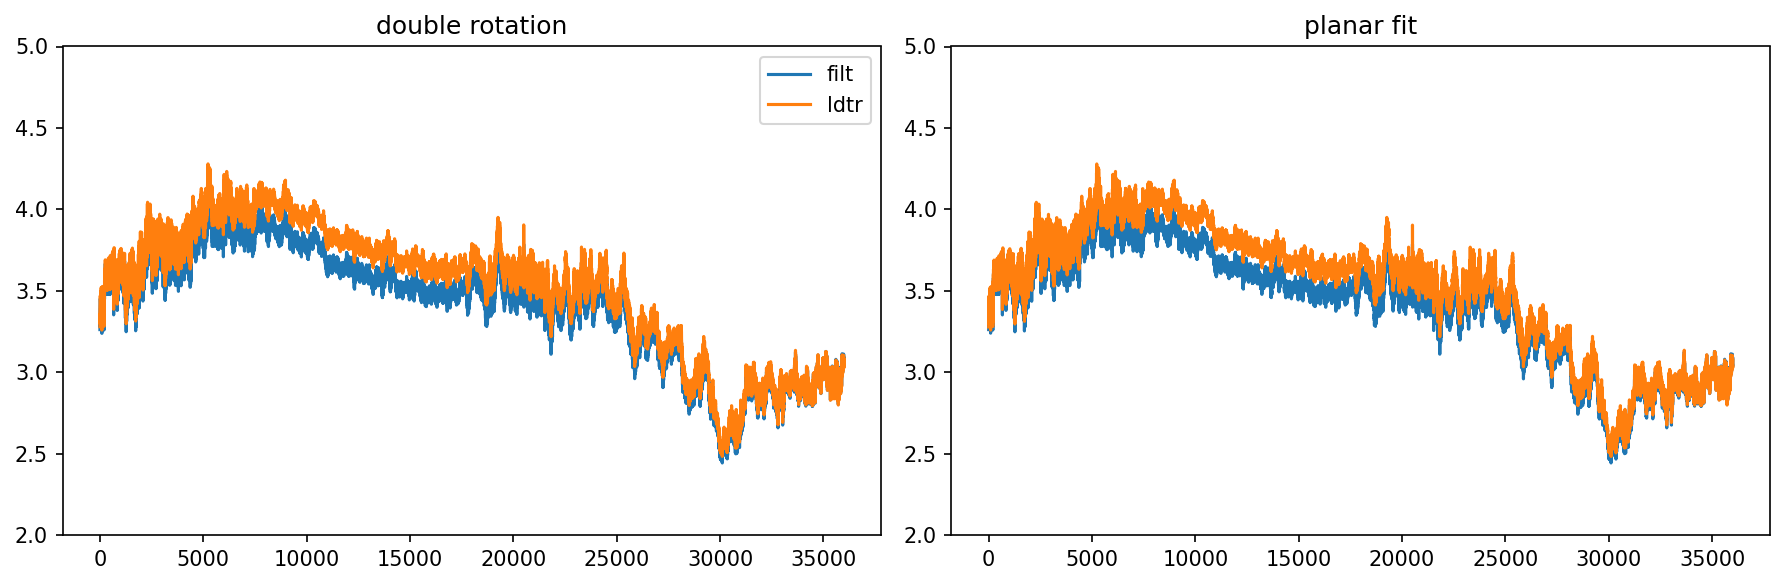

In [86]:
y_lim = (2,5)
level = 6
fig = plt.figure(figsize=(12, 4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121) 
plt.plot(u_filt1[:,level],label = 'filt')
plt.plot(u_ldtr1[:,level],label = 'ldtr')
plt.legend()
plt.ylim(y_lim)
plt.title('double rotation')
ax2 = fig.add_subplot(122) 
plt.plot(u_filt2[:,level])
plt.plot(u_ldtr2[:,level])
plt.ylim(y_lim)
plt.title('planar fit')

# Extract data for WRF

In [5]:
import glob
import shutil
import os

# Define the input and output directories
OUT_DIR4WRF = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/out4WRF/"
IN_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/"

# Ensure the output directory exists
os.makedirs(OUT_DIR4WRF, exist_ok=True)

# Define the file patterns
patterns = ["T_dspk_20201003*", "T_dspk_20201004*", "T_dspk_20201005*"]

# Loop through each pattern, find matching files, and copy them to the output directory
for pattern in patterns:
    for file_path in glob.glob(os.path.join(IN_DIR, pattern)):
        shutil.copy(file_path, OUT_DIR4WRF)
        print(f"Copied {file_path} to {OUT_DIR4WRF}")

Copied /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/T_dspk_20201003_0000.npy to /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/out4WRF/
Copied /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/T_dspk_20201003_0600.npy to /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/out4WRF/
Copied /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/T_dspk_20201003_0200.npy to /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/out4WRF/
Copied /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/T_dspk_20201003_0500.npy to /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/out4WRF/
Copied /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/T_dspk_20201003_1500.npy to /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/out4WRF/
Copied /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_processed_data_091424/T_dspk_20201003_0100.npy to /projectnb/urbanclimate/yueqin/idaho_ec_jupyter/out4WRF